In [35]:
import numpy as np
import pandas as pd

In [36]:
tickers = ["BRK","MMC","PGR","ALL","AJG","MET","PRU","TRV","AIG","FNF","MKL","FAF","HIG","BRO","AIZ","AFL","UNM"]
dataframes = []

for ticker in tickers:
    dataframes.append(pd.read_csv("FinancialNumbers_"+ticker+".csv"))

for i in range(len(tickers)):
    dataframes[i]['Date'] = pd.to_datetime(dataframes[i]['Date'])
    dataframes[i].set_index('Date', inplace=True)

In [37]:
dataframes[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2014-12-31 to 2024-03-31
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Total Assets                 38 non-null     int64
 1   Retained Earnings            38 non-null     int64
 2   EBIT                         38 non-null     int64
 3   Shareholders' Equity         38 non-null     int64
 4   Cash & Equivalents           38 non-null     int64
 5   Property, Plant & Equipment  38 non-null     int64
 6   Total Debt                   38 non-null     int64
 7   Working Capital              38 non-null     int64
 8   Total Liabilities            38 non-null     int64
dtypes: int64(9)
memory usage: 3.0 KB


In [38]:
for i in range(len(dataframes)):
    print(list(dataframes[i].columns))

['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equipment', 'Total Debt', 'Working Capital', 'Total Liabilities']
['Total Assets', 'Retained Earnings', 'EBIT', "Shareholders' Equity", 'Cash & Equivalents', 'Property, Plant & Equi

In [39]:
def calcRatios(TotalAssets, RetainedEarnings, EBIT, WorkingCapital, Equity, TotalLiabilities):
    WCTA = WorkingCapital/TotalAssets
    RETA = RetainedEarnings/TotalAssets
    EBITTA = EBIT/TotalAssets
    BVETL = Equity/TotalLiabilities
    return [WCTA, RETA, EBITTA, BVETL]

In [40]:
def AltmanZScore(ratios):
    return ratios[0]*6.56 + ratios[1]*3.26 + ratios[2]*6.72 + ratios[3]*1.05

In [41]:
dataframes[0].tail()

,Total Assets,Retained Earnings,EBIT,Shareholders' Equity,Cash & Equivalents,"Property, Plant & Equipment",Total Debt,Working Capital,Total Liabilities
Date,,,,,,,,,
2023-03-31,997072,546631,45282,516260,26747,205855,123624,67410,480812
2023-06-30,1041573,582543,46173,551761,50055,209188,125347,76972,489812
2023-09-30,1019933,569776,-15961,534727,30840,211498,124781,92562,485206
2023-12-31,1069978,607350,47702,570770,38022,221870,133570,173170,499208
2024-03-31,1070035,619925,16529,577785,35549,217500,122754,119906,492250


In [42]:
from xgboost import XGBRegressor

In [43]:
#First forecast - LSTM 1 step forward for BRK
target_columns = ["Total Assets", "Retained Earnings", "EBIT", "Shareholders' Equity", "Working Capital", "Total Liabilities"]

In [44]:
# Define lag function for feature engineering
def create_lag_features(df, col, lags=3):
    df_lag = df[[col]].copy()
    for lag in range(1, lags+1):
        df_lag[f"{col}_lag{lag}"] = df_lag[col].shift(lag)
    df_lag.dropna(inplace=True)  # Remove NaNs created by shifting
    return df_lag

In [45]:
predictions = []
models_all = []

for i in range(len(dataframes)):  # Loop through each company
    # Initialize models and predictions for this company
    models = {}
    prediction = {}

    # Get the company's dataframe
    df_company = dataframes[i]

    # Train an XGBoost model for each target column
    for col in target_columns:
        # Create lagged features
        df_lagged = create_lag_features(df_company, col, lags=3)

        # Split into training data (X, y)
        X_train, y_train = df_lagged.iloc[:-1, 1:], df_lagged.iloc[:-1, 0]  # All but last row for training
        X_test = df_lagged.iloc[-1:, 1:]  # Last row as input for prediction

        # Define and train XGBoost model
        model = XGBRegressor(objective="reg:squarederror", n_estimators=100)
        model.fit(X_train, y_train)

        # Predict the next step
        pred = model.predict(X_test)[0]

        # Store model and prediction
        models[col] = model
        prediction[col] = pred

    predictions.append(prediction)
    models_all.append(models)


In [46]:
# Print forecasted values for 1 step ahead
for i in range(len(tickers)):
    print(f"1-Step Ahead Forecasted Values for {tickers[i]}:\n")
    for col, value in predictions[i].items():
        print(f"{col}: {value:.2f}\n")

1-Step Ahead Forecasted Values for BRK:

Total Assets: 1020515.94

Retained Earnings: 568303.88

EBIT: 27994.48

Shareholders' Equity: 556841.81

Working Capital: 68338.38

Total Liabilities: 485206.06

1-Step Ahead Forecasted Values for MMC:

Total Assets: 47490.49

Retained Earnings: 22758.97

EBIT: 1654.72

Shareholders' Equity: 10599.00

Working Capital: 1361.35

Total Liabilities: 36356.14

1-Step Ahead Forecasted Values for PGR:

Total Assets: 88690.92

Retained Earnings: 18800.98

EBIT: 2243.66

Shareholders' Equity: 18557.83

Working Capital: 8505.11

Total Liabilities: 68413.98

1-Step Ahead Forecasted Values for ALL:

Total Assets: 88690.92

Retained Earnings: 18800.98

EBIT: 2243.66

Shareholders' Equity: 18557.83

Working Capital: 16959.48

Total Liabilities: 85907.12

1-Step Ahead Forecasted Values for AJG:

Total Assets: 52537.61

Retained Earnings: 4053.00

EBIT: 710.18

Shareholders' Equity: 11344.00

Working Capital: 971.60

Total Liabilities: 42080.55

1-Step Ahead Fo

In [47]:
#Calculate the ratios then get the Altman Z-score
AltmanZScores = []
for i in range(len(tickers)):
    TotalAssets = predictions[i]['Total Assets']
    RetainedEarnings = predictions[i]['Retained Earnings']
    EBIT = predictions[i]['EBIT']
    ShareholderEquity = predictions[i]["Shareholders' Equity"]
    WorkingCapital = predictions[i]['Working Capital']
    TotalLiabilities = predictions[i]['Total Liabilities']
    ratios = calcRatios(TotalAssets, RetainedEarnings, EBIT, WorkingCapital, ShareholderEquity, TotalLiabilities)
    ZScore = AltmanZScore(ratios)
    print(tickers[i]," ",ZScore)
    AltmanZScores.append(ZScore)   

BRK   3.6440757155418395
MMC   2.2905980950593947
PGR   1.7749633494019508
ALL   2.342290446162224
AJG   0.7467034797370433
MET   0.8367549193650483
PRU   0.1834219726547599
TRV   1.9228326805680989
AIG   0.37060858234763144
FNF   0.6654079067707062
MKL   2.4616478213667867
FAF   -0.4388834953308106
HIG   1.5948351129889486
BRO   2.0698660279810426
AIZ   3.9379523864388464
AFL   2.3207333059608932
UNM   2.150920888930559


In [48]:
#now make the confusion matrix
actuals_allcompanies = pd.read_csv("Actuals.csv")
actuals_allcompanies

,Ticker,High Risk
0,BRK,0
1,MMC,0
2,PGR,1
3,ALL,0
4,AJG,1
5,MET,1
6,PRU,1
7,TRV,0
8,AIG,1
9,FNF,1


In [49]:
high_risk = [0 if(i > 1.95) else 1 for i in AltmanZScores]
high_risk

[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]

In [50]:
#confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
actual_labels = actuals_allcompanies['High Risk'].values
conf_matrix = confusion_matrix(actual_labels, high_risk)
print("Confusion Matrix: \n", conf_matrix)

Confusion Matrix: 
 [[8 1]
 [0 8]]


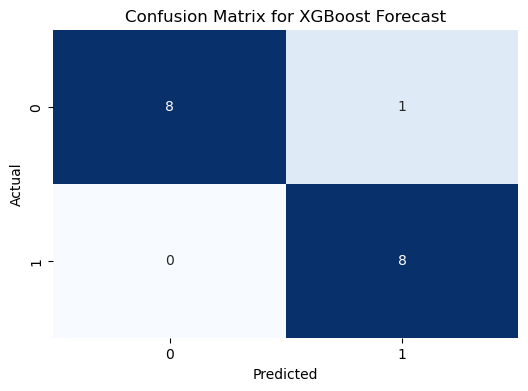

In [51]:
#graph confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for XGBoost Forecast")
plt.show()

In [52]:
# Classification Report (Precision, Recall, F1-score)
report = classification_report(actual_labels, high_risk)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.89      1.00      0.94         8

    accuracy                           0.94        17
   macro avg       0.94      0.94      0.94        17
weighted avg       0.95      0.94      0.94        17

